# Находим топ CR для нескольких приложений по интересам
- с исходными интересами
- с укрупненными интересами

In [1]:
import pandas as pd

# interests
ClickHouse https://redash.trg.corp.mail.ru/queries/28482/source

In [6]:
interests_path = '/home/eka.volkova/dictionaries/interests.csv' # target_id = 5
interests = pd.read_csv(interests_path)

In [7]:
interests.rename(columns={'value': 'interests', 'description': 'interest_name'}, inplace=True)
interests['interests'] = interests['interests'].astype('int64')
interests.set_index('interests', inplace=True)

In [8]:
interests.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 364 entries, 8493 to 7295
Data columns (total 1 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   interest_name  364 non-null    object
dtypes: object(1)
memory usage: 5.7+ KB


In [9]:
interests.head(3)

,interest_name
interests,
8493,Бизнес / Финансы и бухгалтерский учет
16669,Мобильная связь и доступ в интернет / Активные...
7394,Спорт и активный отдых / Активный отдых


# rb_mobile_app_id
Загружаем инфу по приложениям из выборки https://redash.trg.corp.mail.ru/queries/28422/source

In [87]:
rb_mobile_app_id_path = '/home/eka.volkova/TRG-92930_filter_interests/dictionaries/rb_mobile_app_id_2022_12_16.csv'
rb_mobile_app_id = pd.read_csv(rb_mobile_app_id_path)
rb_mobile_app_id.rename(columns={'rb_mobile_app_id': 'app'}, inplace=True)
rb_mobile_app_id.drop_duplicates('app', inplace=True, ignore_index=True)
rb_mobile_app_id.set_index('app', inplace=True)
rb_mobile_app_id.drop(index=0, inplace=True)

In [88]:
rb_mobile_app_id.head(3)

,title,category
app,,
1514710,"Авиабилеты, отели и РЖД билеты",Путешествия
14407,Едадил: скидки в магазинах,Покупки
5050552,Дуэль Художников: Игры по сети,Словесные игры


In [89]:
rb_mobile_app_id.shape

(668, 2)

In [85]:
rb_mobile_app_id.reset_index()[rb_mobile_app_id.reset_index().duplicated('app')]['app'].to_list()

[9750906, 6410058]

In [86]:
rb_mobile_app_id.loc[rb_mobile_app_id.reset_index()[rb_mobile_app_id.reset_index().duplicated('app')]['app'].to_list()]

,title,category
app,,
9750906,Кавёр - афиша событий и мест,Развлечения
9750906,Кавёр - уникальные мероприятия,Мероприятия
6410058,Моя Москва — приложение mos.ru,Социальные
6410058,455871,Другое


# Загружаем выборку за 1 день с исходными и укрупненными категориями

In [17]:
orig_interests = pd.read_csv('./show_install_test.csv', sep=';')
orig_interests.replace(to_replace={'ev_type': 7}, value=1, inplace=True)

In [19]:
upd_interests = pd.read_csv('./show_install_test_upd_interests.csv', sep=';')
upd_interests.replace(to_replace={'ev_type': 7}, value=1, inplace=True)

In [20]:
upd_interests['ev_type'].value_counts()

0    35959598
1     1348852
Name: ev_type, dtype: int64

In [45]:
orig_interests['ev_type'].count()

37308450

# Находим приложения из разных категорий с самым большим количеством просмотров

## Считаем количество показов и инсталлов по каждому приложению

In [137]:
top_app = orig_interests.groupby(by=['app']).agg(
    shows=pd.NamedAgg('ev_type', 'count'), 
    installs=pd.NamedAgg('ev_type', 'sum')
).reset_index()

In [138]:
top_app.head()

,app,shows,installs
0,0,2468,2468
1,73,2180,6
2,97,31217,832
3,99,42,42
4,100,16778,282


In [139]:
top_app.sum()

app         4752696954
shows         37308450
installs       1348852
dtype: int64

## Добавляем расшифровку приложений

In [140]:
top_app = top_app.join(rb_mobile_app_id, on='app')

In [141]:
top_app.head()

,app,shows,installs,title,category
0,0,2468,2468,NaN,NaN
1,73,2180,6,Почта Mail.ru: почтовый ящик,Связь
2,97,31217,832,Одноклассники: Социальная сеть,Социальные
3,99,42,42,Облако Mail.ru: Хранилище фото,Работа
4,100,16778,282,Облако Mail.ru: Диск для фото,Производительность


In [142]:
top_app['shows'].sum()

37308450

In [143]:
top_app.groupby(by=['category', 'app', 'title'], dropna=False)['shows'].sum().sort_values(ascending=False).reset_index()['shows'].sum()

37308450

## Находим топ приложение в каждой категории

In [144]:
top_app = top_app.groupby(by=['category', 'app', 'title'], dropna=False)['shows'].sum().sort_values(ascending=False).reset_index().\
groupby(by=['category'], dropna=False).head(1)

In [147]:
top_app.head(8)

,category,app,title,shows
0,Покупки,3413183,Hoff: мебель и товары для дома,1683840
1,Развлечения,10153236,VK Клипы: короткие видео,1467714
8,Финансы,4882,Тинькофф онлайн банк,792334
10,Социальные,10021784,"YAPPY: видео, креатив, мы",627747
13,Социальные сети,10153235,VK Clips: short videos,569117
15,Стратегии,6091560,Age of Origins,542240
16,Еда и напитки,1514339,"Додо Пицца: доставка, ресторан",535648
19,Пазлы,10423032,Cat Rescue - Спасите кошку,435863
25,Книги и справочники,1801595,Строки от МТС,359590
26,Инструменты,10382460,Яндекс — с Алисой,355605


## + добавляем 2 дополнительных приложения

In [153]:
top_app = [3413183, 10153236, 4882, 10153235, 6091560, 1514339, 4590577, 1001] + [1516891, 2512029]

# CR по приложениям и интересам

## orig_interests

In [216]:
orig_cr = orig_interests.query('app == @top_app').groupby(by=['app', 'interests'])['ev_type'].mean().rename('cr').\
reset_index().sort_values(by=['app', 'cr'], ascending=[True, False], ignore_index=True).\
groupby(by=['app']).head(10)

orig_cr = orig_cr.join(rb_mobile_app_id, on='app').join(interests, on='interests')
orig_cr['app_name'] = orig_cr.apply(lambda raw: f"{raw['title']} ({raw['app']}) / {raw['category']}", axis=1)

In [217]:
orig_cr.head()

,app,interests,cr,title,category,interest_name,app_name
0,1001,10269,0.285714,Яндекс Карты и Навигатор,Карты и навигация,Бизнес / B2B / Реклама и маркетинг,Яндекс Карты и Навигатор (1001) / Карты и нави...
1,1001,9416,0.250000,Яндекс Карты и Навигатор,Карты и навигация,Авто по маркам / Jeep,Яндекс Карты и Навигатор (1001) / Карты и нави...
2,1001,12666,0.250000,Яндекс Карты и Навигатор,Карты и навигация,Авто по маркам / Datsun,Яндекс Карты и Навигатор (1001) / Карты и нави...
3,1001,9420,0.200000,Яндекс Карты и Навигатор,Карты и навигация,Авто по маркам / SEAT,Яндекс Карты и Навигатор (1001) / Карты и нави...
4,1001,11048,0.172414,Яндекс Карты и Навигатор,Карты и навигация,Бытовая техника / Микроволновки,Яндекс Карты и Навигатор (1001) / Карты и нави...


## upd_interests

In [218]:
upd_cr = upd_interests.query('app == @top_app').groupby(by=['app', 'interests'])['ev_type'].mean().rename('cr').\
reset_index().sort_values(by=['app', 'cr'], ascending=[True, False], ignore_index=True).\
groupby(by=['app']).head(10)

upd_cr = upd_cr.join(rb_mobile_app_id, on='app').join(interests, on='interests')
upd_cr['app_name'] = upd_cr.apply(lambda raw: f"{raw['title']} ({raw['app']}) / {raw['category']}", axis=1)

In [219]:
upd_cr.head()

,app,interests,cr,title,category,interest_name,app_name
0,1001,7379,0.161290,Яндекс Карты и Навигатор,Карты и навигация,Бытовая техника / Мелкая кухонная техника,Яндекс Карты и Навигатор (1001) / Карты и нави...
1,1001,25169,0.125000,Яндекс Карты и Навигатор,Карты и навигация,Музыкальные предпочтения / Классическая музыка,Яндекс Карты и Навигатор (1001) / Карты и нави...
2,1001,8838,0.119048,Яндекс Карты и Навигатор,Карты и навигация,Авто по маркам / УАЗ,Яндекс Карты и Навигатор (1001) / Карты и нави...
3,1001,9450,0.114035,Яндекс Карты и Навигатор,Карты и навигация,Туризм / Восточное средиземноморье,Яндекс Карты и Навигатор (1001) / Карты и нави...
4,1001,10274,0.111111,Яндекс Карты и Навигатор,Карты и навигация,Бизнес / B2B / Медицинское оборудование,Яндекс Карты и Навигатор (1001) / Карты и нави...


# Добавляем график по интересам и приложениям

In [258]:
len(orig_cr['interest_name'].unique())*40

2640

In [186]:
import plotly.graph_objects as go
import plotly.express as px

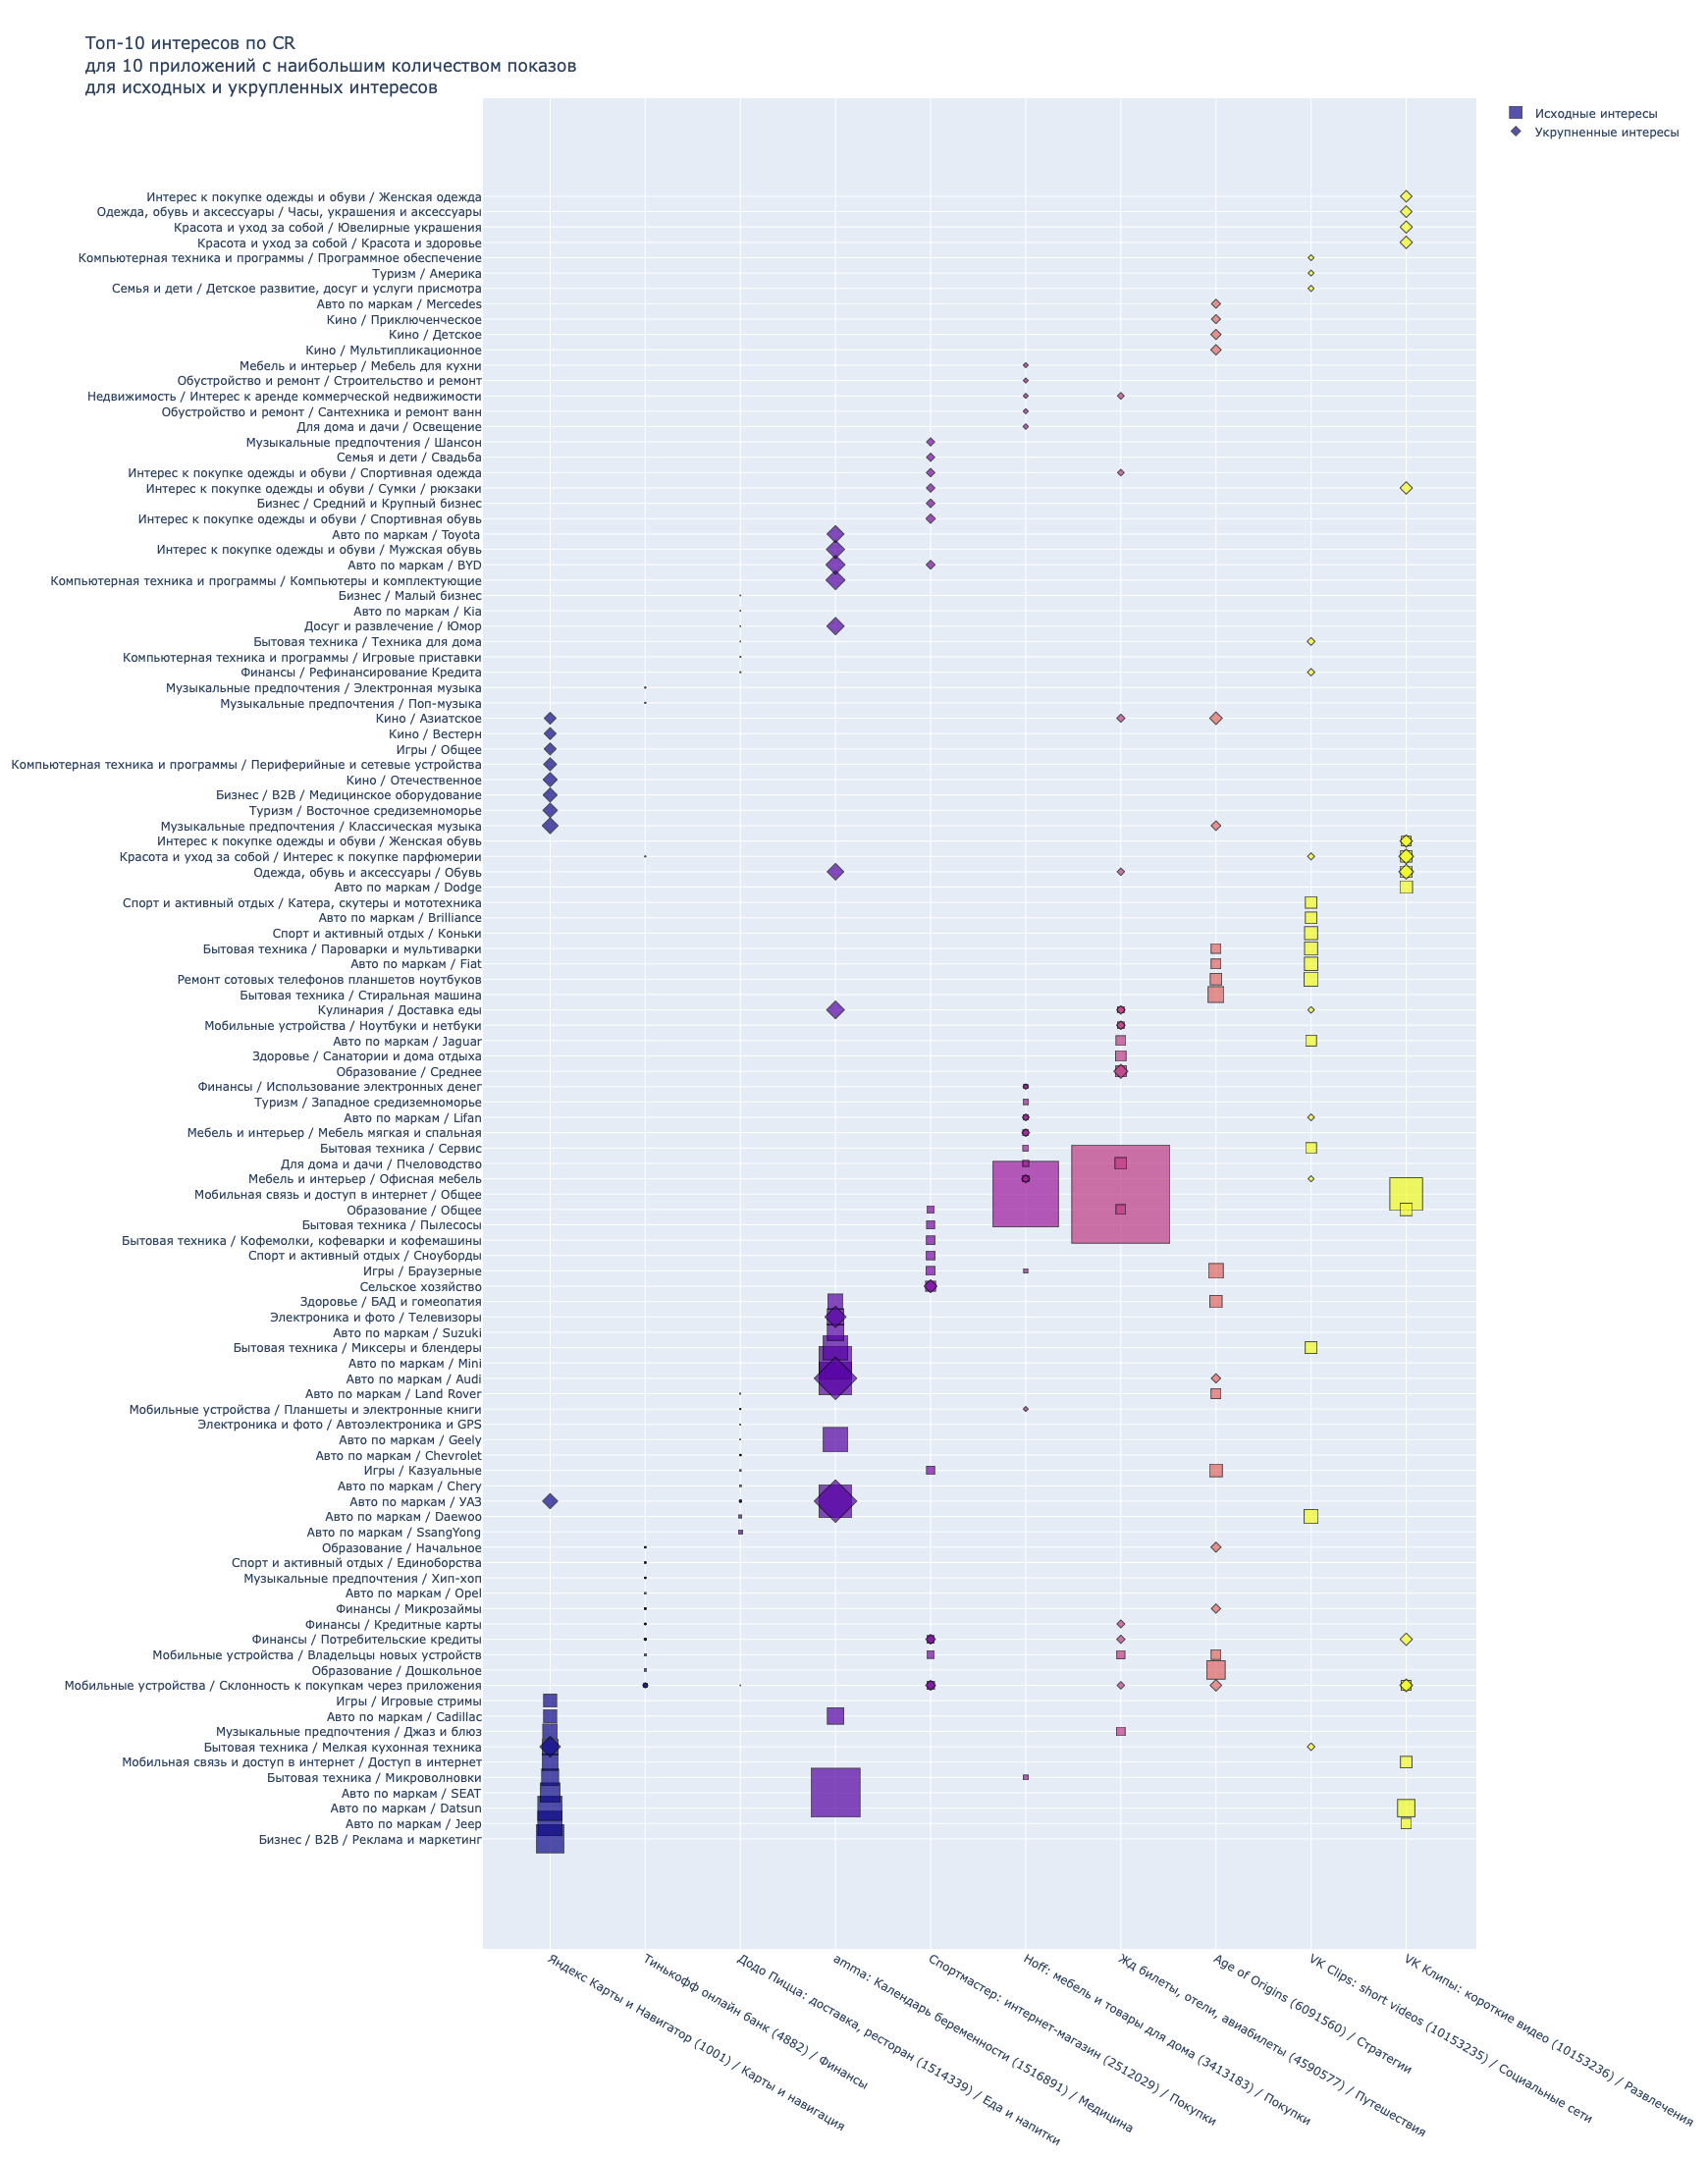

In [276]:
fig = go.Figure()
fig.add_trace(go.Scatter(
    name='Исходные интересы',
    x=orig_cr['app_name'], 
    y=orig_cr['interest_name'], 
    mode='markers', 
    marker=dict(size=orig_cr['cr']*100, color=orig_cr['app'], symbol='square', line=dict(color='black')),
    text=orig_cr['cr'],
    hovertemplate = "%{x}<br>%{y}</br>cr: %{text}"
    )
)
fig.add_trace(go.Scatter(
    name='Укрупненные интересы',
    x=upd_cr['app_name'], 
    y=upd_cr['interest_name'], 
    mode='markers', 
    marker=dict(size=upd_cr['cr']*100, color=upd_cr['app'], symbol='diamond', line=dict(color='black')),
    text=orig_cr['cr'],
    hovertemplate = "%{x}<br>%{y}</br>cr: %{text}"
    )
)
fig.update_layout(
    title=dict(
        text='Топ-10 интересов по CR<br>для 10 приложений с наибольшим количеством показов<br>для исходных и укрупленных интересов'), 
    width=1700,
    height=2200)
fig.show()

In [263]:
fig.write_html("./orig_upd_interests.html")

```![Getting Started](./orig_upd_interests.png)```
![Getting Started](./orig_upd_interests.png)